In [1]:
import sys, os

# add the project root to sys.path
root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root not in sys.path:
    sys.path.insert(0, root)

import importlib
import frengression
# importlib.reload(frengression)
from data_causl.utils import *
from data_causl.data import *
from frengression import *
from lifelines import KaplanMeierFitter, CoxPHFitter
import math

device = torch.device('cpu')
from CausalEGM import *

import numpy as np
import jax.numpy as jnp
import pickle
import os
from tqdm import tqdm
import src.exp_utils as exp_utils

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import copy
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss
from scipy.stats import norm, gaussian_kde
import warnings

warnings.filterwarnings("ignore")


In [2]:


def missing_impute(y, x=None, z=None, x_dim=1, z_dim=1, missing_to_num=-1):
    # Create a copy of y to work on
    y_out = y.clone()  # or copy.deepcopy(y) if you prefer
    # Create an event indicator: 1 where y > 0, else 0.
    event_indicator = (y_out > 0).float()
    # Compute the cumulative sum along the time dimension.
    c = torch.cumsum(event_indicator, dim=1)
    # Shift the cumulative sum one time step to the right.
    c_shifted = torch.zeros_like(c)
    c_shifted[:, 1:] = c[:, :-1]
    # Create a mask that is True for time steps after the first event (i.e., where c_shifted > 0)
    mask = (c_shifted > 0)
    # Mask the y_out values after the first event.
    y_out[mask] = missing_to_num

    # If neither x nor z is provided, return only y_out.
    if x is None and z is None:
        return y_out

    n_obs, timesteps = y.shape  # infer number of observations and timesteps from y

    # Process x if provided.
    x_out = None
    if x is not None:
        # Reshape to (n_obs, timesteps, x_dim)
        x_out = x.clone().view(n_obs, timesteps, x_dim)
        # Expand mask to cover the x_dim features.
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, x_dim)
        # Apply the mask to x_out.
        x_out[mask_expanded] = missing_to_num
        # Reshape x_out back to its original shape.
        x_out = x_out.view(n_obs, timesteps * x_dim)

    # Process z if provided.
    z_out = None
    if z is not None:

        # Reshape to (n_obs, timesteps, z_dim)
        z_out = z.clone().view(n_obs, timesteps, z_dim)
        # Expand mask to cover the z_dim features.
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, z_dim)
        # Apply the mask to z_out.
        z_out[mask_expanded] = missing_to_num
        # Reshape z_out back to its original shape.
        z_out = z_out.view(n_obs, timesteps * z_dim)

    return x_out, z_out, y_out


def long_to_surv(y):
    num_individuals, num_time_points = y.shape
    times = []
    events = []

    for i in range(num_individuals):
        individual = y[i].tolist()
        try:
            # Find the index of the first event (1)
            event_time = individual.index(1) + 1  # +1 if time starts at 1
            event = 1
        except ValueError:
            # If no event occurred, censor at the last time point
            event_time = num_time_points
            event = 0
        
        times.append(event_time)
        events.append(event)

    df = pd.DataFrame({
        'time': times,
        'event': events,
    })
    return df
def plot_survival_time_distribution(df_ground_truth, df_estimate, x_value):
    """
    Plots the distribution of survival times for Ground Truth and FR Estimate.

    Parameters:
    - df_ground_truth: DataFrame containing 'time' for Ground Truth.
    - df_estimate: DataFrame containing 'time' for FR Estimate.
    - x_value: The value of x (0 or 1) being plotted.
    """
    plt.figure(figsize=(10, 7))
    
    # Plot Ground Truth Distribution
    sns.kdeplot(data=df_ground_truth, x='time', fill=True, color='blue', label='Ground Truth', alpha=0.5)
    
    # Plot FR Estimate Distribution
    sns.kdeplot(data=df_estimate, x='time', fill=True, color='green', label='FR Estimate', alpha=0.5)
    
    # Customize the plot
    plt.title(f'Survival Time Distribution for x={x_value}')
    plt.xlabel('Time')
    plt.ylabel('Density')
    plt.grid(True)
    plt.legend()
    plt.show()


In [ ]:
s,x,z,y = generate_data_survivl(n=10000,T=10, random_seed=42, C_coeff=0.1, setting = 1)

In [4]:
y

array([[ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [ 1., nan, nan, ..., nan, nan, nan],
       [ 0.,  1., nan, ..., nan, nan, nan],
       [ 1., nan, nan, ..., nan, nan, nan]])

In [28]:
s,x,z,y = generate_data_survivl(n=5000,T=10, random_seed=42, C_coeff=0.1, setting = 2)
s_tr = torch.tensor(s, dtype=torch.float32)
s_tr = torch.cat([s_tr,s_tr,s_tr], dim=1)
x_tr = torch.tensor(x, dtype=torch.int32)
y_tr = torch.tensor(y, dtype=torch.int32)
z_tr = torch.nan_to_num(torch.tensor(z, dtype=torch.float32))
z_tr = torch.cat([z_tr,z_tr,z_tr], dim=1)

model = FrengressionSurv(x_dim=1, y_dim=1, z_dim=3, T=10, s_dim = 3, noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True, y_binary=True)
# model.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=1500, lr=1e-4, print_every_iter=500)

In [29]:
s_tr.shape

torch.Size([5000, 3])

In [30]:
s_tr

tensor([[1.8245, 1.8245, 1.8245],
        [0.4441, 0.4441, 0.4441],
        [0.7796, 0.7796, 0.7796],
        ...,
        [0.1816, 0.1816, 0.1816],
        [0.7424, 0.7424, 0.7424],
        [1.8149, 1.8149, 1.8149]])

In [31]:
model.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=3500, lr=1e-4, print_every_iter=500, reg_lambda=0)

Epoch 1: loss 4.5350,	loss_y 1.5735, 1.5891, 0.0311,	loss_eta 2.9615, 3.0915, 0.2600, 	marginal_loss 2.3456
Epoch 500: loss 3.0251,	loss_y 0.8357, 1.4494, 1.2274,	loss_eta 2.1894, 4.4743, 4.5699, 	marginal_loss 8.5366
Epoch 1000: loss 2.4142,	loss_y 0.2043, 0.3685, 0.3284,	loss_eta 2.2099, 4.6163, 4.8129, 	marginal_loss 8.5732
Epoch 1500: loss 2.2266,	loss_y 0.0599, 0.1080, 0.0961,	loss_eta 2.1667, 4.4300, 4.5266, 	marginal_loss 8.5516
Epoch 2000: loss 2.2075,	loss_y 0.0379, 0.0653, 0.0549,	loss_eta 2.1696, 4.3760, 4.4127, 	marginal_loss 8.4644
Epoch 2500: loss 2.1940,	loss_y 0.0223, 0.0392, 0.0339,	loss_eta 2.1717, 4.3586, 4.3738, 	marginal_loss 8.5754
Epoch 3000: loss 2.2005,	loss_y 0.0186, 0.0285, 0.0199,	loss_eta 2.1819, 4.3573, 4.3508, 	marginal_loss 8.4740
Epoch 3500: loss 2.1954,	loss_y 0.0110, 0.0177, 0.0136,	loss_eta 2.1844, 4.3543, 4.3397, 	marginal_loss 8.5138


In [6]:
model.train_xz(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=500, lr=1e-4, print_every_iter=500)

Epoch 1: loss 5.6280, loss1 5.7628, loss2 0.2697
Epoch 500: loss 1.6123, loss1 3.2493, loss2 3.2740


In [10]:
y_tr.float().mean()

tensor(0.0994)

In [7]:
x_pred,z_pred,y_pred = model.sample_joint(s=s_tr)

In [8]:
z_pred

tensor([[ 0.0268,  0.7909, -0.0926,  ..., -0.0074, -0.0312, -0.0202],
        [-0.1583,  1.3226,  0.2001,  ...,  0.9678, -0.7708, -1.2408],
        [-1.4230, -0.4221,  0.2756,  ...,  0.2682,  0.5060,  0.6730],
        ...,
        [-0.7754,  2.4505,  2.1209,  ...,  1.3085,  0.9963,  0.5368],
        [ 0.1134,  0.2692,  0.8776,  ...,  0.8968,  1.0125, -0.3853],
        [-0.0696, -0.2200, -0.2644,  ..., -0.6670,  0.3928, -0.2080]])

In [9]:
z_tr

tensor([[ 0.1865,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.2532,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.5645,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.8464,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3038,  0.9819,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.3758, -0.7267,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [10]:
x_tr

tensor([[3.3115,    nan,    nan,  ...,    nan,    nan,    nan],
        [3.0468,    nan,    nan,  ...,    nan,    nan,    nan],
        [0.4541,    nan,    nan,  ...,    nan,    nan,    nan],
        ...,
        [2.9632,    nan,    nan,  ...,    nan,    nan,    nan],
        [2.7814, 3.5375,    nan,  ...,    nan,    nan,    nan],
        [1.2831, 1.3278,    nan,  ...,    nan,    nan,    nan]])

In [11]:
z_tr

tensor([[ 0.1865,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.2532,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.5645,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.8464,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3038,  0.9819,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.3758, -0.7267,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [45]:
z_pred

tensor([[-0.9819,  1.2784,  1.9162,  ..., -0.4180, -1.2131, -0.3144],
        [ 0.0603,  1.3026,  1.4995,  ..., -1.5490,  0.6302,  1.7578],
        [-1.2773,  0.7588,  1.7736,  ...,  0.9755,  0.1301,  1.1783],
        ...,
        [ 0.1599,  1.6337,  1.2500,  ..., -0.9316, -0.9987,  1.8018],
        [-0.9929,  1.6236,  0.6103,  ..., -0.2167,  2.5586,  0.6828],
        [-0.2133,  0.6129,  0.1418,  ..., -0.2232, -0.8498, -0.2698]])

In [12]:
missing_impute(y=y_pred, x=x_pred, z=z_pred)

(tensor([[ 2.9668, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [ 0.8140, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [ 2.8477,  3.6335,  2.8324,  ...,  1.3323,  1.4639,  0.7282],
         ...,
         [ 2.4107,  1.7551,  2.4000,  ..., -1.0000, -1.0000, -1.0000],
         [ 2.9989,  2.7739,  2.7278,  ...,  1.7596,  1.9774,  1.9177],
         [ 1.2901, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]),
 tensor([[ 0.0268, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-0.2929, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [ 0.3784,  1.4478,  2.0247,  ..., -0.6000,  0.7429,  0.9350],
         ...,
         [-1.0241,  1.0622,  1.3402,  ..., -1.0000, -1.0000, -1.0000],
         [-0.1002,  1.6303,  0.9692,  ...,  2.7253,  0.5674,  0.9988],
         [-1.5497, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]),
 tensor([[ 1., -1., -1.,  ..., -1., -1., -1.],
         [ 1., -1., -1.,  ..., -1., -1., -1.],
         [ 0.,  0.,  0

In [57]:
missing_impute(y=y_tr, x=x_tr, z=z_tr)

(tensor([[ 3.3115, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [ 3.0468, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [ 0.4541, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [ 2.9632, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [ 2.7814,  3.5375, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [ 1.2831,  1.3278, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]),
 tensor([[ 0.1865, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-0.2532, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-0.5645, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-0.8464, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-0.3038,  0.9819, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [ 0.3758, -0.7267, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]),
 tensor([[ 1, -1, -1,  ..., -1, -1, -1],
         [ 1, -1, -1,  ..., -1, -1, -1],
         [ 1, -1, -1,  ..., -1, -1

In [39]:
x_pred

tensor([[2.7132, 4.0375, 3.2200,  ..., 2.3892, 2.6599, 3.4138],
        [2.8578, 3.0699, 2.7401,  ..., 2.3323, 2.0439, 2.7395],
        [1.0744, 0.9953, 1.2246,  ..., 1.1275, 1.0019, 1.1448],
        ...,
        [2.6034, 3.5294, 2.9835,  ..., 2.2102, 1.8448, 2.3789],
        [2.7689, 3.2979, 3.1178,  ..., 2.0721, 2.5408, 2.1633],
        [1.1935, 1.2304, 1.3721,  ..., 1.3837, 1.1643, 0.5770]])

## Setting 1

In [ ]:
s,x,z,y = generate_data_survivl(n=10000,T=10, random_seed=42, C_coeff=0.1, setting = 1)
s_tr = torch.tensor(s, dtype=torch.int32)
x_tr = torch.tensor(x, dtype=torch.float32)
y_tr = torch.tensor(y, dtype=torch.int32)
z_tr = torch.nan_to_num(torch.tensor(z, dtype=torch.float32))

model1 = FrengressionSurv(x_dim=1, y_dim=1, z_dim=1, T=10, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True, y_binary=True)
model1.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=2000, lr=1e-4, print_every_iter=500)

Epoch 1: loss 4.5686,	loss_y 1.5770, 1.5941, 0.0343,	loss_eta 2.9917, 3.1089, 0.2345, 	marginal_loss 0.5247
Epoch 1: y_sample_mean 0.34463000297546387
Epoch 1: y_sample1_cat.float().mean() 0.5104130506515503
Epoch 500: loss 3.2187,	loss_y 1.0341, 1.7455, 1.4228,	loss_eta 2.1846, 4.3679, 4.3665, 	marginal_loss 0.0087
Epoch 500: y_sample_mean 0.34571999311447144
Epoch 500: y_sample1_cat.float().mean() 0.3675493896007538
Epoch 1000: loss 3.1283,	loss_y 0.9508, 1.7382, 1.5748,	loss_eta 2.1775, 4.3402, 4.3255, 	marginal_loss 0.0033
Epoch 1000: y_sample_mean 0.34387001395225525
Epoch 1000: y_sample1_cat.float().mean() 0.3573480546474457
Epoch 1500: loss 3.0212,	loss_y 0.8313, 1.5652, 1.4679,	loss_eta 2.1899, 4.3427, 4.3055, 	marginal_loss 0.0009
Epoch 1500: y_sample_mean 0.3439599871635437
Epoch 1500: y_sample1_cat.float().mean() 0.35084831714630127
Epoch 2000: loss 2.9462,	loss_y 0.7644, 1.4551, 1.3814,	loss_eta 2.1818, 4.3511, 4.3386, 	marginal_loss 0.0013
Epoch 2000: y_sample_mean 0.34112

In [ ]:

# torch.manual_seed(42)
C=0

y_x1 = missing_impute(model1.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[1]*10],dtype=torch.int32),sample_size=1000))
y_x1 = y_x1.reshape(1000, 10)                                            
df_x1 = long_to_surv(y_x1)
y_x0 = missing_impute(model1.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[0]*10],dtype=torch.int32),sample_size=1000))
y_x0 = y_x0.reshape(1000, 10)     
df_x0 = long_to_surv(y_x0)


mu_x0 = 0.3+0.1*C  # mean parameter
mu_x1 = 0.5+0.1*C
phi=1

n_samples = 2000
time_step = 1  
max_time = math.ceil(10) 
time_points = np.arange(1, max_time+1 , time_step) 

# x=0
gamma_dist_x0 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x0)
continuous_survival_times = gamma_dist_x0.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x0 = long_to_surv(binary_data)

# x=1
gamma_dist_x1 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x1)
continuous_survival_times = gamma_dist_x1.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x1 = long_to_surv(binary_data)

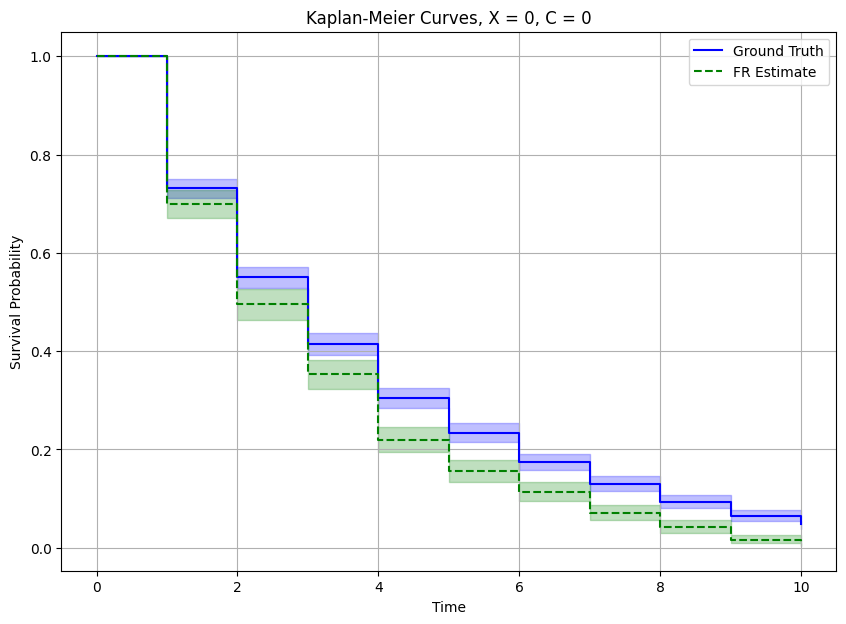

In [15]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x0['time'], event_observed=df_binary_x0['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x0['time'], event_observed=df_x0['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 0, C = 0')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

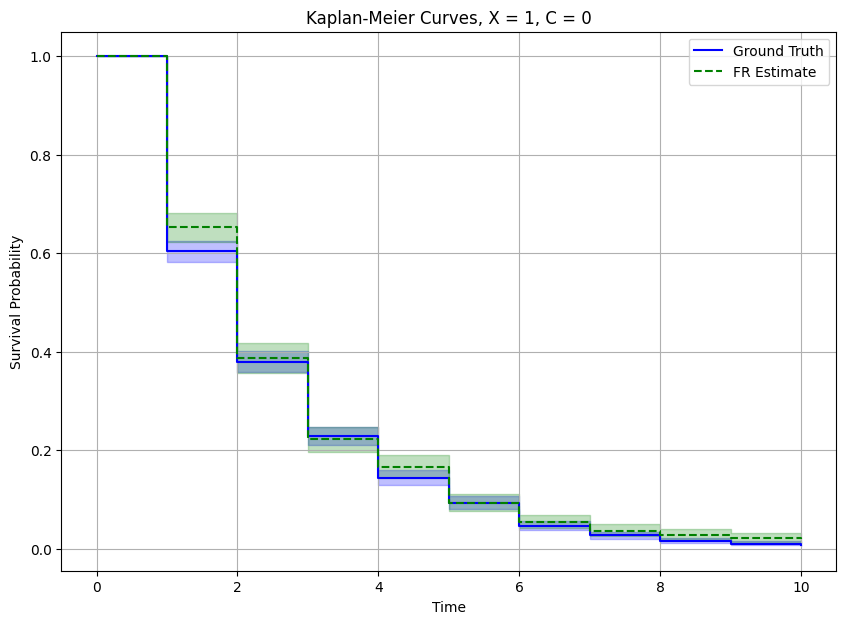

In [16]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x1['time'], event_observed=df_binary_x1['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x1['time'], event_observed=df_x1['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 1, C = 0')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

In [ ]:

# torch.manual_seed(42)
C=1

y_x1 = missing_impute(model1.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[1]*10],dtype=torch.int32),sample_size=1000))
y_x1 = y_x1.reshape(1000, 10)  
df_x1 = long_to_surv(y_x1)

y_x0 = missing_impute(model1.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[0]*10],dtype=torch.int32),sample_size=1000))
y_x0 = y_x0.reshape(1000, 10)  
df_x0 = long_to_surv(y_x0)


mu_x0 = 0.3+0.1*C  # mean parameter
mu_x1 = 0.5+0.1*C
phi=1

n_samples = 2000
time_step = 1  
max_time = math.ceil(10) 
time_points = np.arange(1, max_time+1 , time_step) 

# x=0
gamma_dist_x0 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x0)
continuous_survival_times = gamma_dist_x0.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x0 = long_to_surv(binary_data)

# x=1
gamma_dist_x1 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x1)
continuous_survival_times = gamma_dist_x1.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x1 = long_to_surv(binary_data)

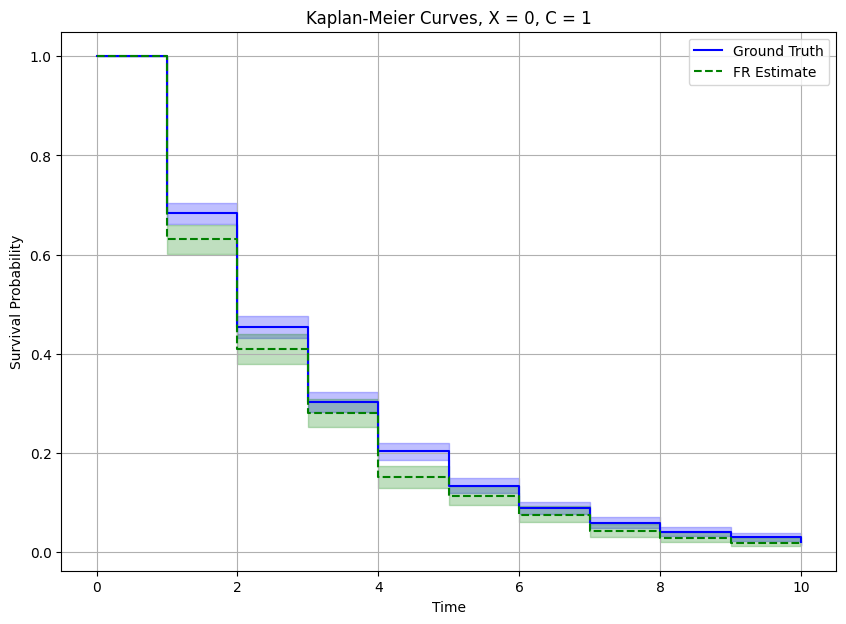

In [19]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x0['time'], event_observed=df_binary_x0['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x0['time'], event_observed=df_x0['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 0, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

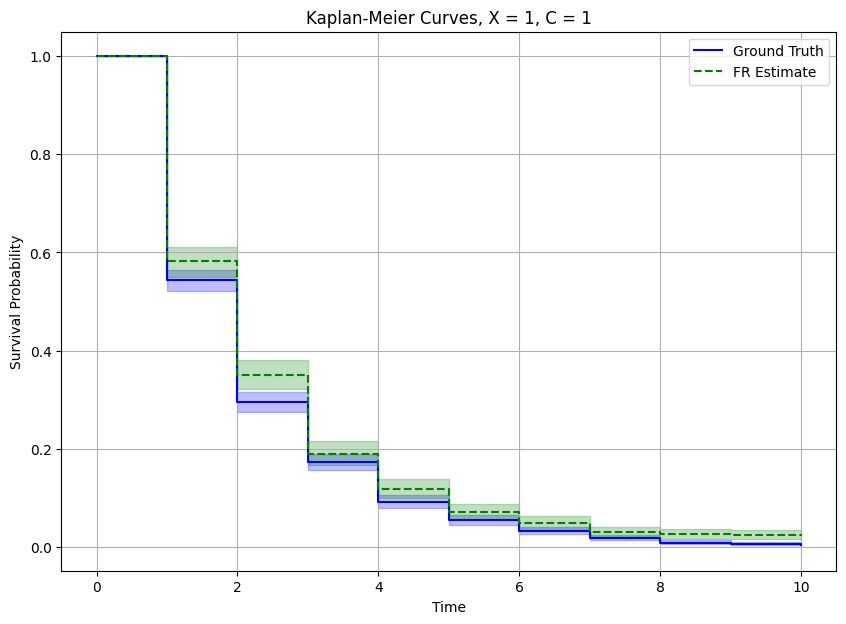

In [20]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x1['time'], event_observed=df_binary_x1['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x1['time'], event_observed=df_x1['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 1, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

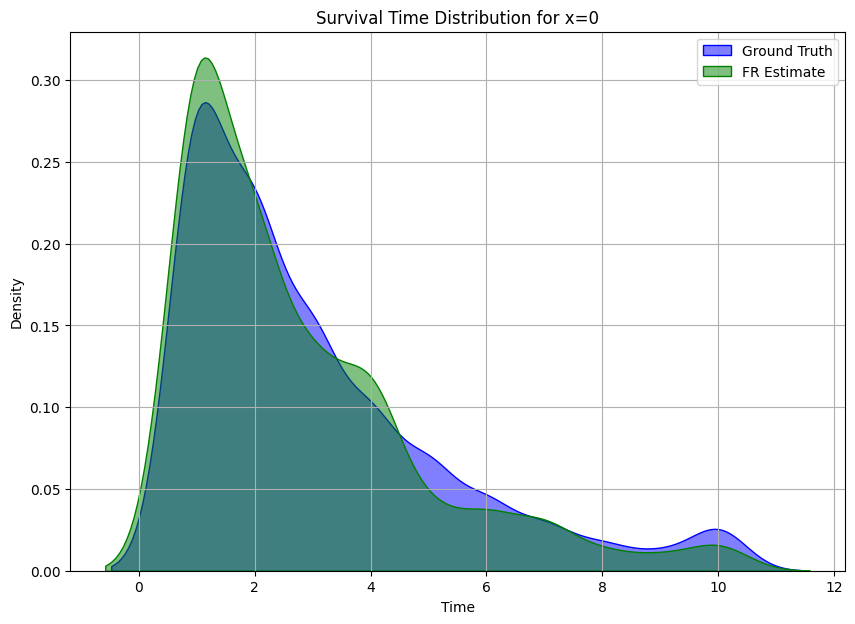

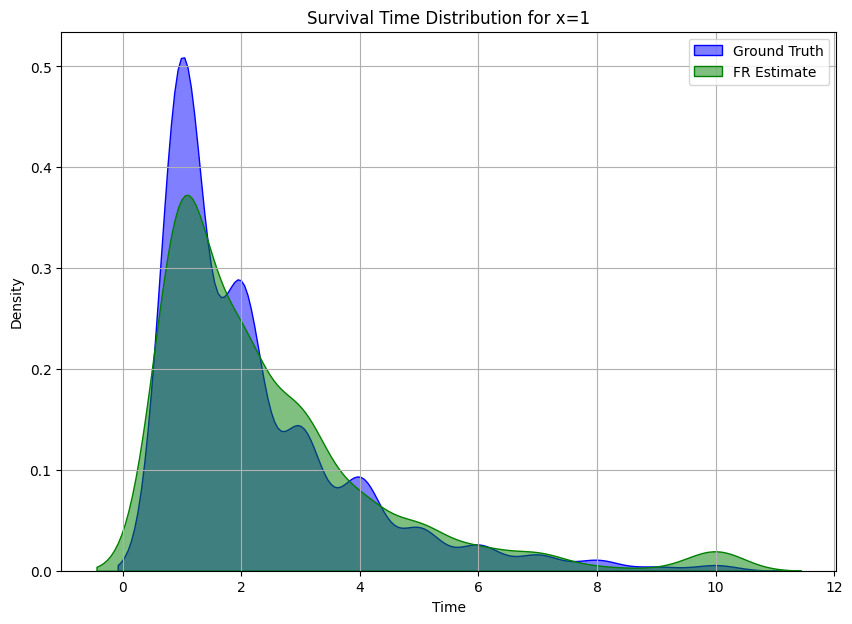

In [21]:
# Distribution for x=0
plot_survival_time_distribution(df_ground_truth=df_binary_x0,
                                df_estimate=df_x0,
                                x_value=0)

# Distribution for x=1
plot_survival_time_distribution(df_ground_truth=df_binary_x1,
                                df_estimate=df_x1,
                                x_value=1)


# Setting 2

In [ ]:
s,x,z,y = generate_data_survivl(n=5000,T=10, random_seed=2025, C_coeff=0.2, setting = 2)
s_tr = torch.tensor(s, dtype=torch.float32)
x_tr = torch.tensor(x, dtype=torch.int32)
y_tr = torch.tensor(y, dtype=torch.int32)
z_tr = torch.nan_to_num(torch.tensor(z, dtype=torch.float32))

model2 = FrengressionSurv(x_dim=1, y_dim=1, z_dim=1, T=10, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True, y_binary=True)
model2.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=1200, lr=1e-4, print_every_iter=500)

Epoch 1: loss 4.5041,	loss_y 1.5641, 1.5804, 0.0325,	loss_eta 2.9400, 3.1169, 0.3537
Epoch 500: loss 3.0819,	loss_y 0.9218, 1.5782, 1.3128,	loss_eta 2.1601, 4.3681, 4.4160
Epoch 1000: loss 2.9610,	loss_y 0.7969, 1.4525, 1.3112,	loss_eta 2.1641, 4.3440, 4.3598


In [ ]:

C=0

y_x1 = missing_impute(model2.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.float32), 
                                            x = torch.tensor([[1]*10],dtype=torch.float32),sample_size=2000))
y_x1 = y_x1.reshape(1000, 10)
df_x1 = long_to_surv(y_x1)
y_x0 = missing_impute(model2.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.float32), 
                                            x = torch.tensor([[0]*10],dtype=torch.int32),sample_size=2000))
y_x0 = y_x0.reshape(1000, 10)
df_x0 = long_to_surv(y_x0)


mu_x0 = 0.5+0.2*C  # mean parameter
mu_x1 = 0.7+0.2*C
phi=1

n_samples = 1000
time_step = 1  
max_time = math.ceil(10) 
time_points = np.arange(1, max_time + 1, time_step) 

# x=0
gamma_dist_x0 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x0)
continuous_survival_times = gamma_dist_x0.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x0 = long_to_surv(binary_data)

# x=1
gamma_dist_x1 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x1)
continuous_survival_times = gamma_dist_x1.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x1 = long_to_surv(binary_data)

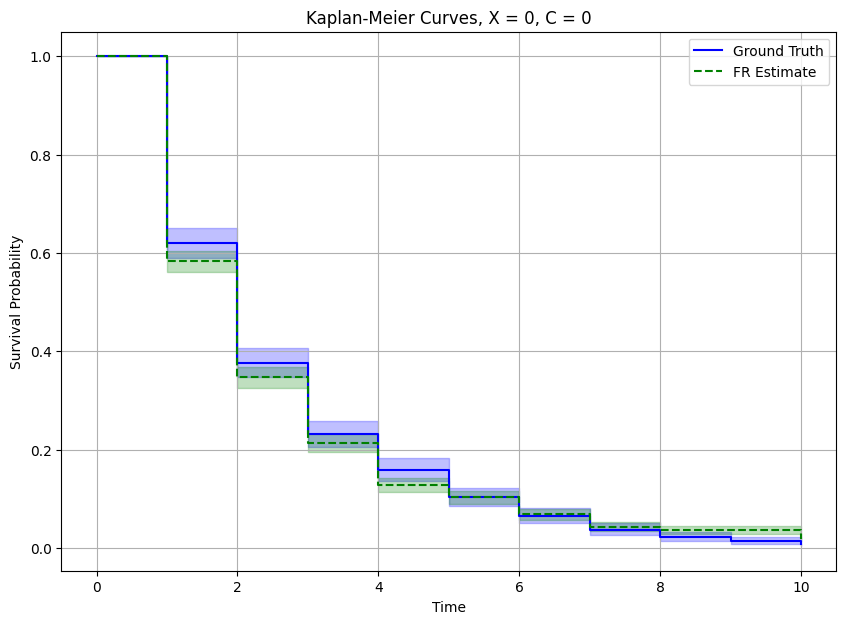

In [51]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x0['time'], event_observed=df_binary_x0['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x0['time'], event_observed=df_x0['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 0, C = 0')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

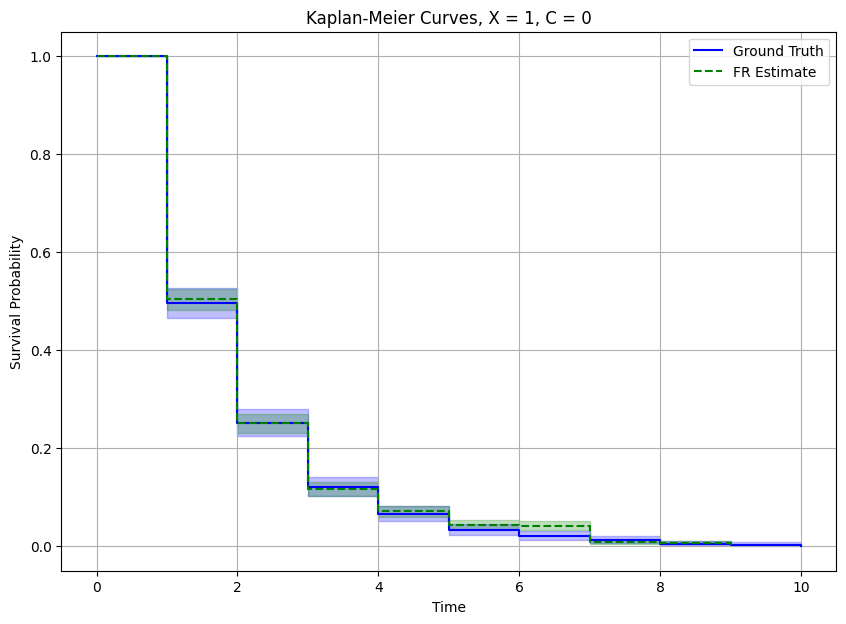

In [52]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x1['time'], event_observed=df_binary_x1['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x1['time'], event_observed=df_x1['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 1, C = 0')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

In [ ]:

torch.manual_seed(42)
C=1

y_x1 = missing_impute(model2.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.float32), 
                                            x = torch.tensor([[1]*10],dtype=torch.int32),sample_size=2000))
y_x1 = y_x1.reshape(1000, 10)                                            
df_x1 = long_to_surv(y_x1)
y_x0 = missing_impute(model2.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.float32), 
                                            x = torch.tensor([[0]*10],dtype=torch.int32),sample_size=2000))
y_x0 = y_x0.reshape(1000, 10)
df_x0 = long_to_surv(y_x0)


mu_x0 = 0.5+0.2*C  # mean parameter
mu_x1 = 0.7+0.2*C
phi=1

n_samples = 2000
time_step = 1  
max_time = math.ceil(10) 
time_points = np.arange(1, max_time + 1, time_step) 

# x=0
gamma_dist_x0 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x0)
continuous_survival_times = gamma_dist_x0.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x0 = long_to_surv(binary_data)

# x=1
gamma_dist_x1 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x1)
continuous_survival_times = gamma_dist_x1.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x1 = long_to_surv(binary_data)

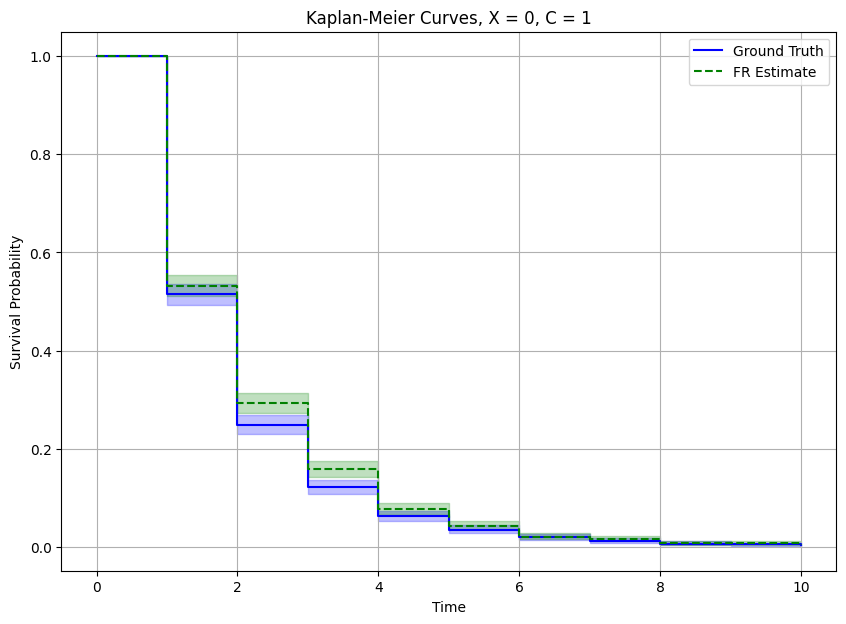

In [54]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x0['time'], event_observed=df_binary_x0['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x0['time'], event_observed=df_x0['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 0, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

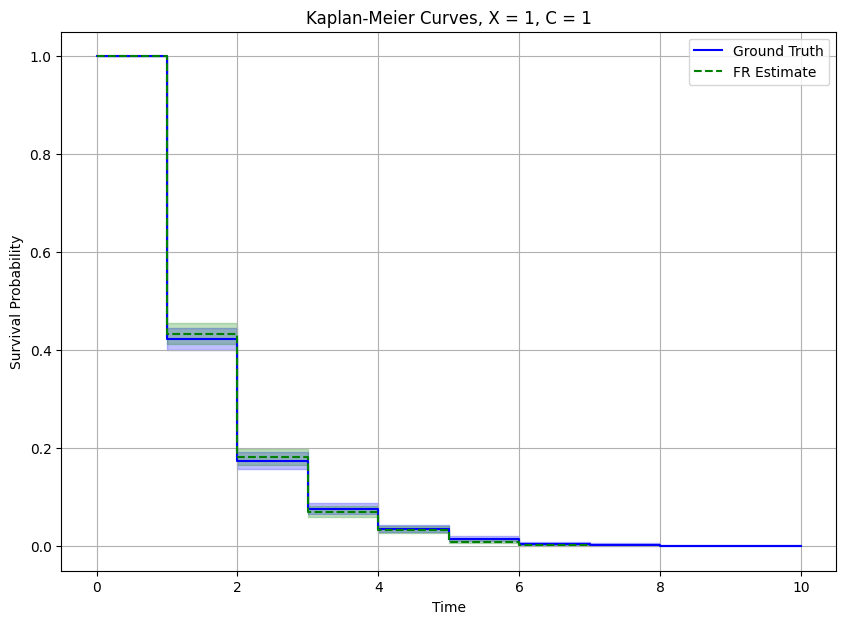

In [55]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x1['time'], event_observed=df_binary_x1['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x1['time'], event_observed=df_x1['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 1, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

# Setting 3

In [ ]:
s,x,z,y = generate_data_survivl(n=5000,T=12, random_seed=2025, C_coeff=0.1, setting=3)
s_tr = torch.tensor(s, dtype=torch.int32)
x_tr = torch.tensor(x, dtype=torch.int32)
y_tr = torch.tensor(y, dtype=torch.int32)
z_tr = torch.nan_to_num(torch.tensor(z, dtype=torch.float32))

model3 = FrengressionSurv(x_dim=1, y_dim=1, z_dim=1, T=12, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True, y_binary=True)
model3.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=1400, lr=1e-4, print_every_iter=200)

Epoch 1: loss 4.9786,	loss_y 1.7211, 1.7380, 0.0337,	loss_eta 3.2575, 3.3859, 0.2568
Epoch 200: loss 3.6172,	loss_y 1.2009, 1.4347, 0.4676,	loss_eta 2.4163, 4.4472, 4.0618
Epoch 400: loss 3.4703,	loss_y 1.0704, 1.4997, 0.8586,	loss_eta 2.3999, 4.8193, 4.8388
Epoch 600: loss 3.3920,	loss_y 0.9843, 1.5746, 1.1807,	loss_eta 2.4077, 4.8208, 4.8262
Epoch 800: loss 3.3581,	loss_y 0.9525, 1.6252, 1.3454,	loss_eta 2.4056, 4.7982, 4.7852
Epoch 1000: loss 3.3214,	loss_y 0.9217, 1.6384, 1.4333,	loss_eta 2.3996, 4.7937, 4.7881
Epoch 1200: loss 3.2857,	loss_y 0.8897, 1.6201, 1.4608,	loss_eta 2.3960, 4.7824, 4.7728
Epoch 1400: loss 3.2375,	loss_y 0.8595, 1.5837, 1.4483,	loss_eta 2.3780, 4.7620, 4.7680


In [ ]:
#torch.manual_seed(42)
C=0

y_x1 = missing_impute(model3.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[1]*12],dtype=torch.int32),sample_size=2000))
y_x1 = y_x1.reshape(1000, 10)
df_x1 = long_to_surv(y_x1)
y_x0 = missing_impute(model3.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[0]*12],dtype=torch.int32),sample_size=2000))
y_x0 = y_x0.reshape(1000, 10)
df_x0 = long_to_surv(y_x0)


mu_x0 = 0.15+0.1*C  # mean parameter
mu_x1 = 0.25+0.1*C
phi=1

n_samples = 3000
time_step = 1  
max_time = math.ceil(12) 
time_points = np.arange(1, max_time + 1, time_step) 

# x=0
gamma_dist_x0 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x0)
continuous_survival_times = gamma_dist_x0.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x0 = long_to_surv(binary_data)

# x=1
gamma_dist_x1 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x1)
continuous_survival_times = gamma_dist_x1.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x1 = long_to_surv(binary_data)

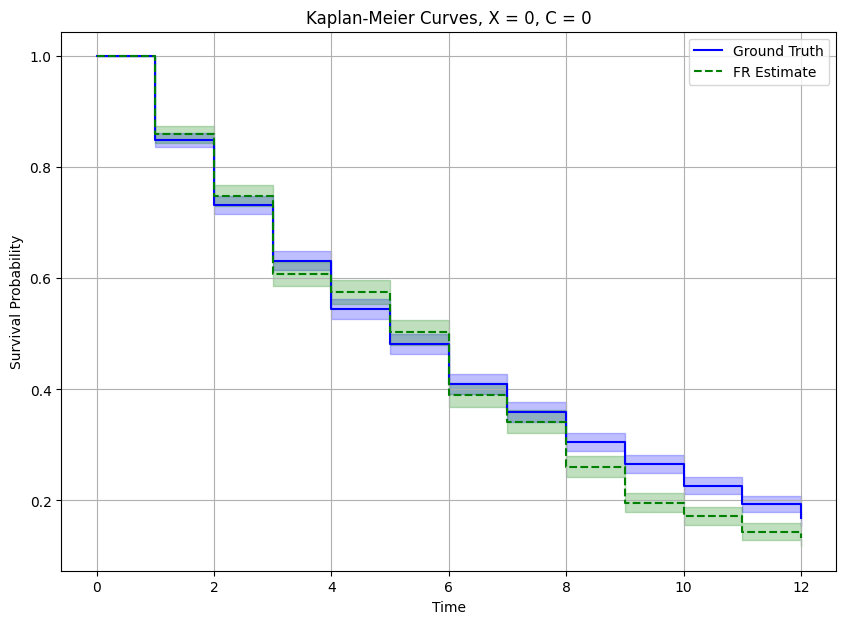

In [31]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x0['time'], event_observed=df_binary_x0['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x0['time'], event_observed=df_x0['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 0, C = 0')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

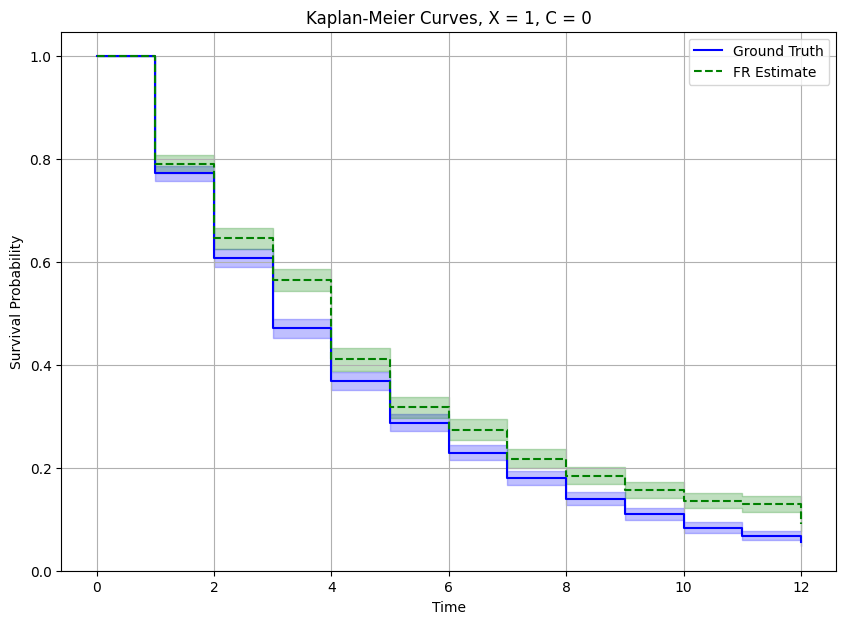

In [32]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x1['time'], event_observed=df_binary_x1['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x1['time'], event_observed=df_x1['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 1, C = 0')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

In [ ]:

#torch.manual_seed(42)
C=1

y_x1 = missing_impute(model3.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[1]*12],dtype=torch.int32),sample_size=1000))
y_x1 = y_x1.reshape(1000, 10)
df_x1 = long_to_surv(y_x1)
y_x0 = missing_impute(model3.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[0]*12],dtype=torch.int32),sample_size=1000))
y_x0 = y_x0.reshape(1000, 10)
df_x0 = long_to_surv(y_x0)


mu_x0 = 0.15+0.1*C  # mean parameter
mu_x1 = 0.25+0.1*C
phi=1

n_samples = 3000
time_step = 1  
max_time = math.ceil(12) 
time_points = np.arange(1, max_time + 1, time_step) 

# x=0
gamma_dist_x0 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x0)
continuous_survival_times = gamma_dist_x0.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x0 = long_to_surv(binary_data)

# x=1
gamma_dist_x1 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x1)
continuous_survival_times = gamma_dist_x1.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x1 = long_to_surv(binary_data)

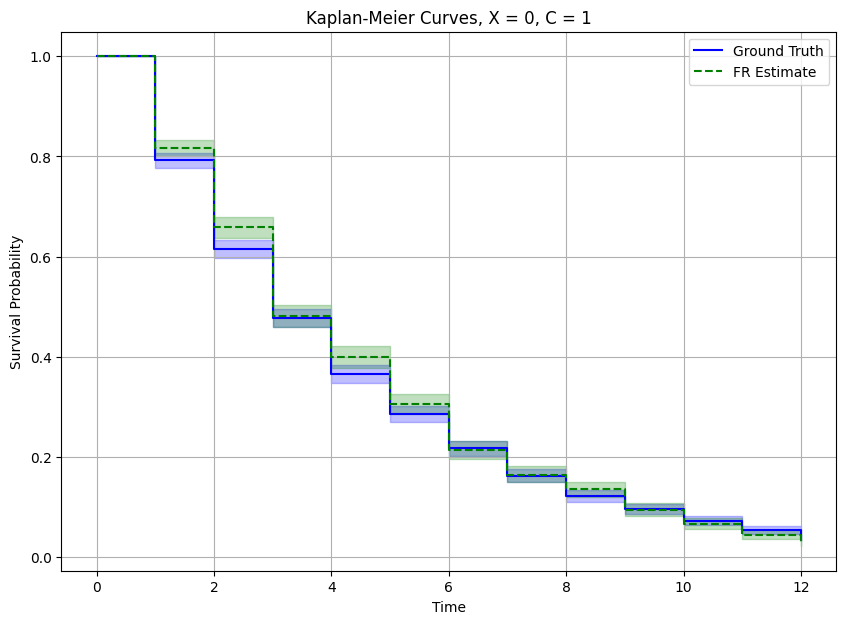

In [34]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x0['time'], event_observed=df_binary_x0['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x0['time'], event_observed=df_x0['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 0, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

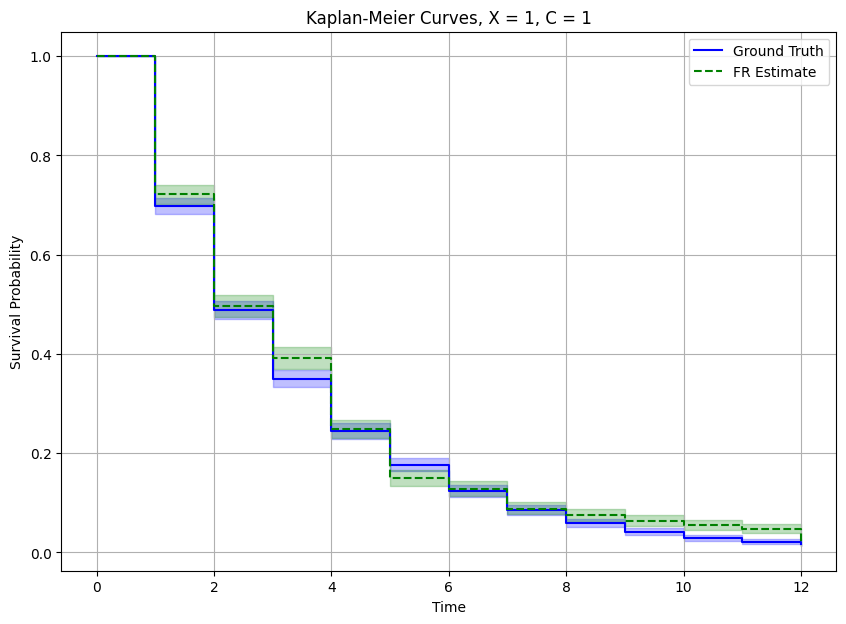

In [35]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x1['time'], event_observed=df_binary_x1['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x1['time'], event_observed=df_x1['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 1, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

# Setting 4

In [10]:
s,x,z,y = generate_data_survivl(n=5000,T=10, random_seed=42, C_coeff=0.1, setting=3)
s_tr = torch.tensor(s, dtype=torch.int32)
x_tr = torch.tensor(x, dtype=torch.float32)
y_tr = torch.tensor(y, dtype=torch.int32)
z_tr = torch.nan_to_num(torch.tensor(z, dtype=torch.float32))

model4 = FrengressionSurv(x_dim=1, y_dim=1, z_dim=1, T=10, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = False, s_in_predict=True, y_binary=True)
model4.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=4000, lr=1e-4, print_every_iter=200)

Epoch 1: loss 4.5349,	loss_y 1.5676, 1.5813, 0.0274,	loss_eta 2.9674, 3.0999, 0.2652, 	marginal_loss 0.2209
Epoch 1: y_sample_mean 0.40077999234199524
Epoch 1: y_sample1_cat.float().mean() 0.5048691630363464
Epoch 200: loss 3.3869,	loss_y 1.2010, 1.6214, 0.8409,	loss_eta 2.1859, 4.0757, 3.7795, 	marginal_loss 0.0130
Epoch 200: y_sample_mean 0.4006200134754181
Epoch 200: y_sample1_cat.float().mean() 0.4281628131866455
Epoch 400: loss 3.2591,	loss_y 1.0653, 1.7619, 1.3932,	loss_eta 2.1939, 4.3773, 4.3669, 	marginal_loss 0.0059
Epoch 400: y_sample_mean 0.4000200033187866
Epoch 400: y_sample1_cat.float().mean() 0.42099055647850037
Epoch 600: loss 3.1929,	loss_y 0.9980, 1.7727, 1.5494,	loss_eta 2.1949, 4.3823, 4.3748, 	marginal_loss 0.0046
Epoch 600: y_sample_mean 0.3980199992656708
Epoch 600: y_sample1_cat.float().mean() 0.41206327080726624
Epoch 800: loss 3.1096,	loss_y 0.9398, 1.7089, 1.5381,	loss_eta 2.1698, 4.3555, 4.3716, 	marginal_loss 0.0027
Epoch 800: y_sample_mean 0.40094000101089

In [24]:
model.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=1000, lr=1e-4, print_every_iter=200)

Epoch 1: loss 2.8076,	loss_y 0.6245, 1.1972, 1.1456,	loss_eta 2.1831, 4.3596, 4.3529
Epoch 200: loss 2.8004,	loss_y 0.6109, 1.1789, 1.1361,	loss_eta 2.1895, 4.3547, 4.3303
Epoch 400: loss 2.7673,	loss_y 0.5989, 1.1705, 1.1433,	loss_eta 2.1685, 4.3485, 4.3602
Epoch 600: loss 2.7636,	loss_y 0.5973, 1.1637, 1.1328,	loss_eta 2.1662, 4.3444, 4.3564
Epoch 800: loss 2.7754,	loss_y 0.6052, 1.1593, 1.1082,	loss_eta 2.1702, 4.3368, 4.3331
Epoch 1000: loss 2.7503,	loss_y 0.5784, 1.1272, 1.0976,	loss_eta 2.1719, 4.3612, 4.3784


In [16]:

#torch.manual_seed(42)
C=1

y_x1 = missing_impute(model4.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[3]*10],dtype=torch.float32),sample_size=1000))
y_x1 = y_x1.reshape(1000, 10)
df_x1 = long_to_surv(y_x1)
y_x0 = missing_impute(model4.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[2]*10],dtype=torch.float32),sample_size=1000))
y_x0 = y_x0.reshape(1000, 10)
df_x0 = long_to_surv(y_x0)


mu_x0 = 0.7+0.1*C  # mean parameter
mu_x1 = 1+0.1*C
phi=1

n_samples = 3000
time_step = 1  
max_time = math.ceil(10) 
time_points = np.arange(1, max_time + 1, time_step) 

# x=0
gamma_dist_x0 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x0)
continuous_survival_times = gamma_dist_x0.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x0 = long_to_surv(binary_data)

# x=1
gamma_dist_x1 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x1)
continuous_survival_times = gamma_dist_x1.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x1 = long_to_surv(binary_data)

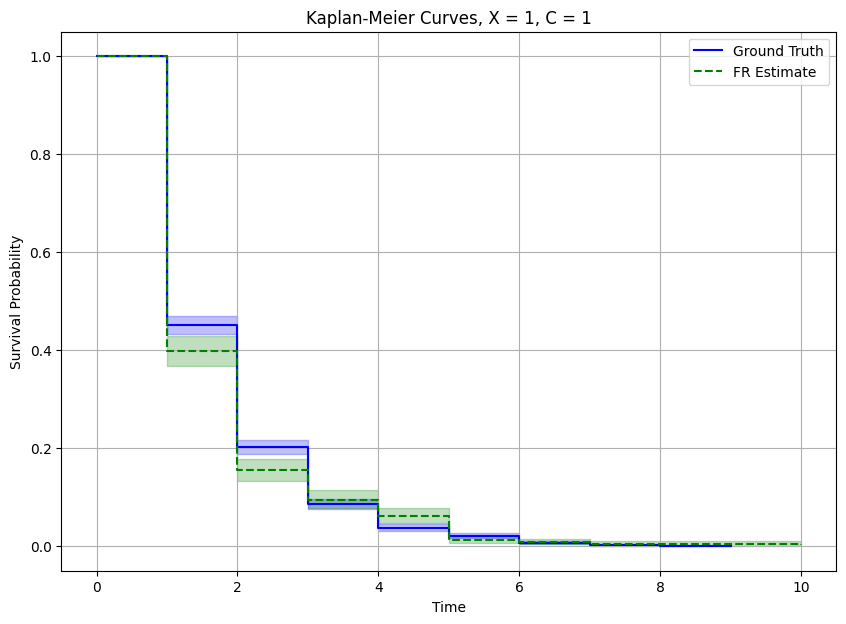

In [17]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x0['time'], event_observed=df_binary_x0['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x0['time'], event_observed=df_x0['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 1, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

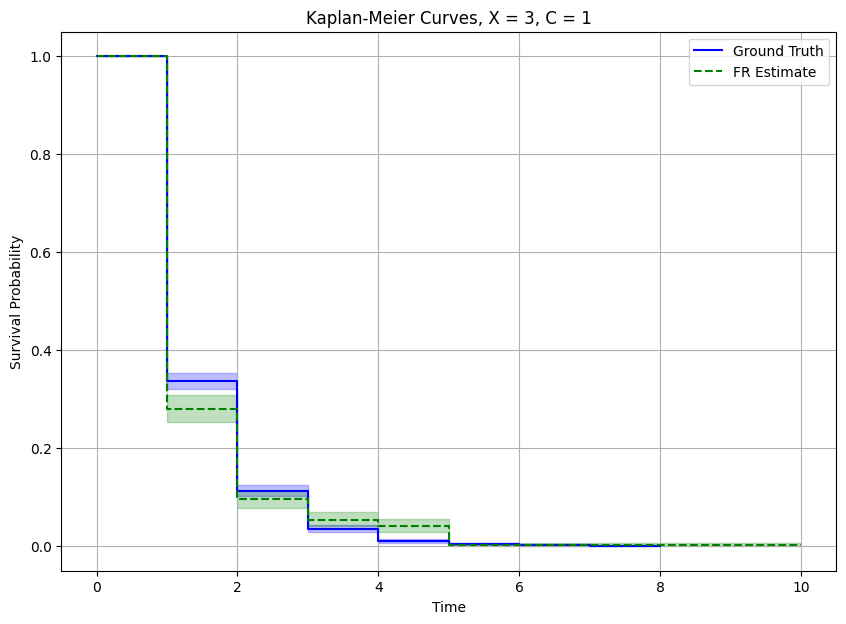

In [18]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x1['time'], event_observed=df_binary_x1['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x1['time'], event_observed=df_x1['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 3, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

Epoch 1: loss 4.5560,	loss_y 1.5732, 1.5889, 0.0314,	loss_eta 2.9827, 3.0968, 0.2282, 	marginal_loss 0.4919
Epoch 1: y_sample_mean 0.3421666622161865
Epoch 1: y_sample1_cat.float().mean() 0.5057345628738403
Epoch 375: loss 3.2332,	loss_y 1.0667, 1.6755, 1.2177,	loss_eta 2.1665, 4.3529, 4.3727, 	marginal_loss 0.0197
Epoch 375: y_sample_mean 0.3399333357810974
Epoch 375: y_sample1_cat.float().mean() 0.3700443506240845
Epoch 750: loss 3.1090,	loss_y 0.9473, 1.7030, 1.5112,	loss_eta 2.1617, 4.3394, 4.3555, 	marginal_loss 0.0070
Epoch 750: y_sample_mean 0.3393166661262512
Epoch 750: y_sample1_cat.float().mean() 0.3567727208137512
Epoch 1125: loss 3.0719,	loss_y 0.8761, 1.6081, 1.4639,	loss_eta 2.1958, 4.3536, 4.3156, 	marginal_loss 0.0014
Epoch 1125: y_sample_mean 0.34193333983421326
Epoch 1125: y_sample1_cat.float().mean() 0.34942877292633057
Epoch 1500: loss 2.9740,	loss_y 0.8104, 1.5021, 1.3835,	loss_eta 2.1636, 4.3442, 4.3612, 	marginal_loss 0.0007
Epoch 1500: y_sample_mean 0.3351833224

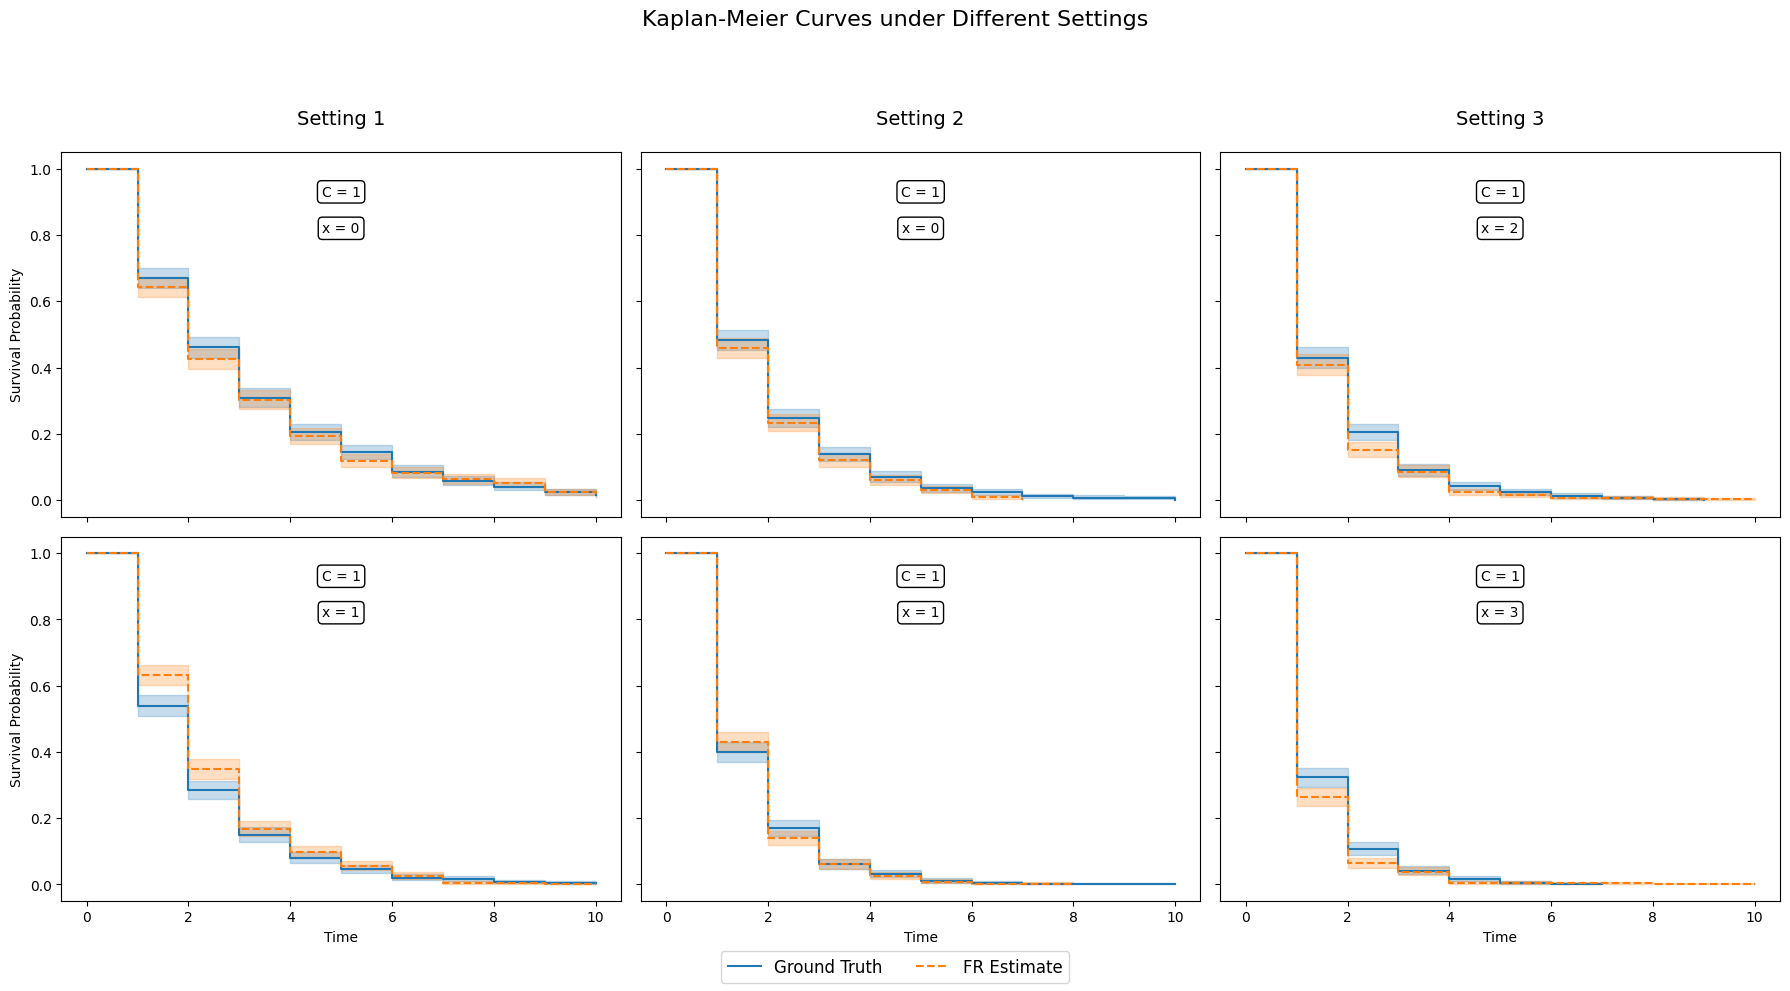

In [27]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

def generate_km_data(
    setting, n, seed, C_coeff, C,
    mu0, mu1, x_vals=(0,1),
    train_iters=2000, lr=1e-4,
    T=10, sample_size=1000, phi=1
):
    """
    Generate KM‐data for one setting:
      • setting, n, seed, C_coeff → simulate & fit FR model with train_iters, lr
      • C → confounder value
      • (mu0, mu1) for true Gamma rates at x_vals
      • x_vals → list/tuple of the two x‐values to evaluate
    Returns dict { x_val: (df_true, df_est) }.
    """
    # 1) simulate & train
    s, x, z, y = generate_data_survivl(n=n, T=T,
                                       random_seed=seed,
                                       C_coeff=C_coeff,
                                       setting=setting)
    s_tr = torch.tensor(s, dtype=torch.int32)
    x_tr = torch.tensor(x, dtype=torch.float32)
    y_tr = torch.tensor(y, dtype=torch.int32)
    z_tr = torch.nan_to_num(torch.tensor(z, dtype=torch.float32))

    model = FrengressionSurv(
        x_dim=1, y_dim=1, z_dim=1, T=T, s_dim=1, noise_dim=1,
        num_layer=3, hidden_dim=100, device=device,
        x_binary=True, s_in_predict=True, y_binary=True
    )
    model.train_y(
        s=s_tr, x=x_tr, z=z_tr, y=y_tr,
        num_iters=train_iters, lr=lr, 
        print_every_iter=max(train_iters//4, 1)
    )

    # 2) sample FR & true for each x_val
    max_time = math.ceil(T)
    times = np.arange(1, max_time + 1)
    mus = { x_vals[0]: mu0, x_vals[1]: mu1 }

    out = {}
    for x_val in x_vals:
        # 2a) FR estimate
        x_repeat = torch.tensor([[x_val]*T], dtype=torch.int32)
        y_samps = missing_impute(
            model.sample_causal_margin(
                s=torch.tensor([[C]], dtype=torch.int32),
                x=x_repeat,
                sample_size=sample_size
            )
        )
        df_est = long_to_surv(y_samps.reshape(sample_size, T))

        # 2b) “True” from Gamma
        gamma = torch.distributions.Gamma(
            concentration=1/phi, rate=mus[x_val]
        )
        cont = gamma.sample((sample_size,)).numpy()

        binary = []
        for st in cont:
            ev, happened = [], False
            for t in times:
                if not happened:
                    if st <= t:
                        ev.append(1)
                        happened = True
                    else:
                        ev.append(0)
                else:
                    ev.append(-1)
            binary.append(ev)

        df_true = long_to_surv(np.array(binary))
        out[x_val] = (df_true, df_est)

    return out

# ——— define your settings with per‐setting train_iters ———
settings = [
    # Setting 1: 2000 its
    dict(
      setting=1, n=6000, seed=42, C_coeff=0.1, C=1,
      mu0=0.3+0.1*1, mu1=0.5+0.1*1,
      x_vals=(0,1),
      train_iters=1500, lr=1e-4
    ),
    # Setting 2: 1200 its
    dict(
      setting=2, n=6000, seed=42, C_coeff=0.2, C=1,
      mu0=0.5+0.2*1, mu1=0.7+0.2*1,
      x_vals=(0,1),
      train_iters=1500, lr=1e-4
    ),
    # Setting 3: 4000 its, x in {1,2}
    dict(
      setting=3, n=6000, seed=42, C_coeff=0.1, C=1,
      mu0=0.7+0.1*1, mu1=1+0.1*1,
      x_vals=(2,3),
      train_iters=5000, lr=1e-4
    ),
]

# ——— generate & plot ———
all_data = [generate_km_data(**p) for p in settings]

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True,
                         figsize=(18, 10))
fig.suptitle("Kaplan-Meier Curves under Different Settings", fontsize=16, y=0.98)

for col, (params, data) in enumerate(zip(settings, all_data)):
    Cval = params['C']
    for row, x_val in enumerate(params['x_vals']):
        ax = axes[row, col]
        df_true, df_est = data[x_val]

        kmf_t = KaplanMeierFitter().fit(
            df_true['time'], df_true['event'], label='Ground Truth'
        )
        kmf_f = KaplanMeierFitter().fit(
            df_est['time'], df_est['event'], label='FR Estimate'
        )

        kmf_t.plot_survival_function(ax=ax, ci_show=True, linestyle='-')
        kmf_f.plot_survival_function(ax=ax, ci_show=True, linestyle='--')

        # remove the small‐subplot legend
        if ax.get_legend() is not None:
            ax.get_legend().remove()

        # annotate C and x
        ax.text(0.5, 0.88, f"C = {Cval}",
                transform=ax.transAxes, ha='center',
                bbox=dict(boxstyle="round,pad=0.3", fc="white"))
        ax.text(0.5, 0.78, f"x = {x_val}",
                transform=ax.transAxes, ha='center',
                bbox=dict(boxstyle="round,pad=0.3", fc="white"))

        if row == 1:
            ax.set_xlabel("Time")
        if col == 0:
            ax.set_ylabel("Survival Probability")

    axes[0, col].set_title(f"Setting {col+1}", pad=20, fontsize=14)

# single legend at lower center
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()



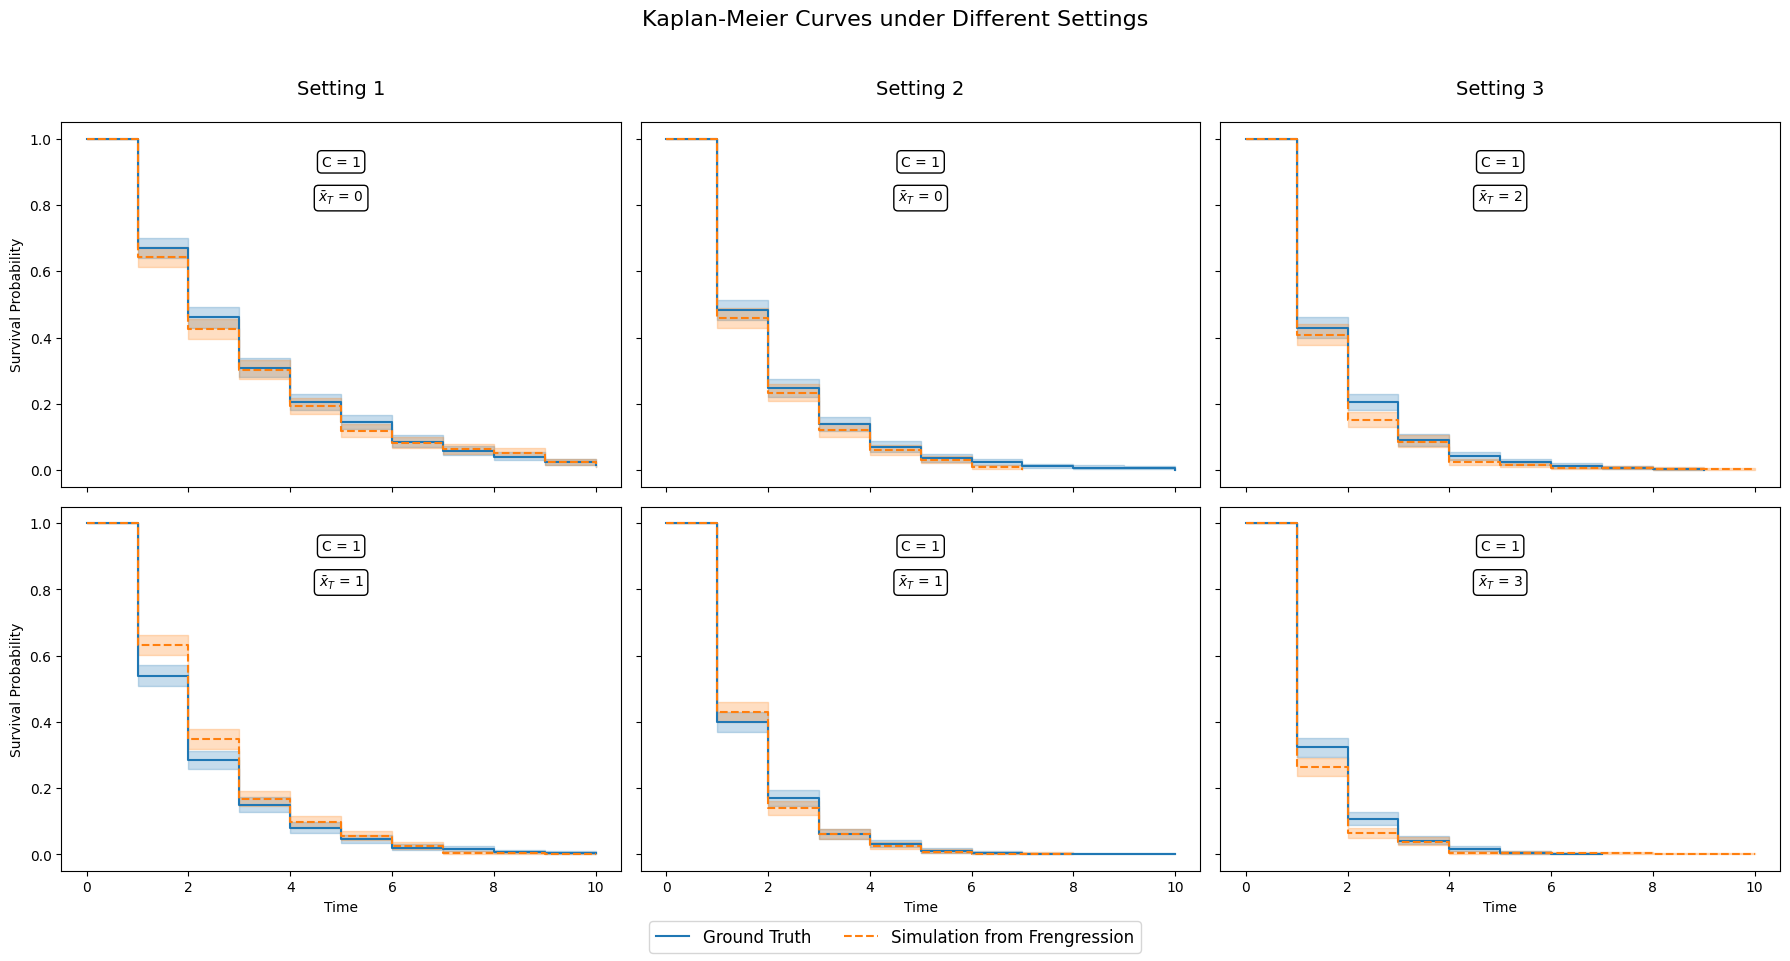

In [32]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True,
                         figsize=(18, 10))
fig.suptitle("Kaplan-Meier Curves under Different Settings", fontsize=16, y=0.95)

for col, (params, data) in enumerate(zip(settings, all_data)):
    Cval = params['C']
    for row, x_val in enumerate(params['x_vals']):
        ax = axes[row, col]
        df_true, df_est = data[x_val]

        kmf_t = KaplanMeierFitter().fit(
            df_true['time'], df_true['event'], label='Ground Truth'
        )
        kmf_f = KaplanMeierFitter().fit(
            df_est['time'], df_est['event'], label='Simulation from Frengression'
        )

        kmf_t.plot_survival_function(ax=ax, ci_show=True, linestyle='-')
        kmf_f.plot_survival_function(ax=ax, ci_show=True, linestyle='--')

        # remove the small‐subplot legend
        if ax.get_legend() is not None:
            ax.get_legend().remove()

        # annotate C and x
        ax.text(0.5, 0.88, f"C = {Cval}",
                transform=ax.transAxes, ha='center',
                bbox=dict(boxstyle="round,pad=0.3", fc="white"))
        ax.text(0.5, 0.78, rf"$\bar{{x}}_T$ = {x_val}",
                transform=ax.transAxes, ha='center',
                bbox=dict(boxstyle="round,pad=0.3", fc="white"))

        if row == 1:
            ax.set_xlabel("Time")
        if col == 0:
            ax.set_ylabel("Survival Probability")

    axes[0, col].set_title(f"Setting {col+1}", pad=20, fontsize=14)

# single legend at lower center
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()